In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import os
os.chdir('/content/drive/MyDrive/2023년_카이스트_금융시계열/1주차실습/1. 금융시계열 실습')

In [5]:
# ARIMA 모형을 이용하여 주가을 예측해 본다.
# 예측 결과를 신뢰할 수 있는가? 없다면 그 원인은 무엇인가 ?

In [4]:
import warnings
warnings.filterwarnings('ignore')
#
# ------------------------------------------------------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from MyUtil.MyTimeSeries import checkNormality
from statsmodels.tsa.arima.model import ARIMA

In [13]:
# 주가 데이터를 읽어온다
p = pd.read_csv('StockData/069500.csv', index_col=0, parse_dates=True)[::-1]
p = p.dropna()

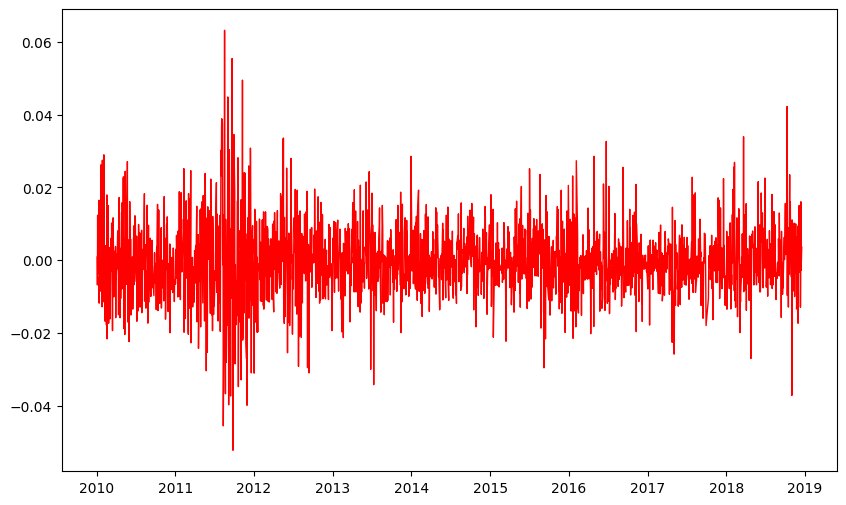

In [14]:
# 종가를 기준으로 일일 수익률을 계산한다.
p['Rtn'] = np.log(p['Close']) - np.log(p['Close'].shift(1))
p = p.dropna()

# 수익률 시계열을 육안으로 확인한다. 이분산성이 있는가?
plt.figure(figsize=(10,6))
plt.plot(p['Rtn'], color='red', linewidth=1)
plt.show()

In [15]:
# 주가 데이터를 ARIMA(2,1,1) 모형으로 분석한다 (Fitting)
y = np.array(pd.to_numeric(p['Close'], downcast='float'))  # int형이면 float형으로 변환한다
model = ARIMA(y, order=(2,1,1))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2190
Model:                 ARIMA(2, 1, 1)   Log Likelihood              -15080.262
Date:                Tue, 24 Oct 2023   AIC                          30168.525
Time:                        03:51:56   BIC                          30191.290
Sample:                             0   HQIC                         30176.845
                               - 2190                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9547      0.083     11.480      0.000       0.792       1.118
ar.L2         -0.0035      0.018     -0.189      0.850      -0.040       0.033
ma.L1         -0.9575      0.083    -11.549      0.0


Shapiro-Wilks 검정 : 검정통계량 = 0.2016, p-value = 0.0000


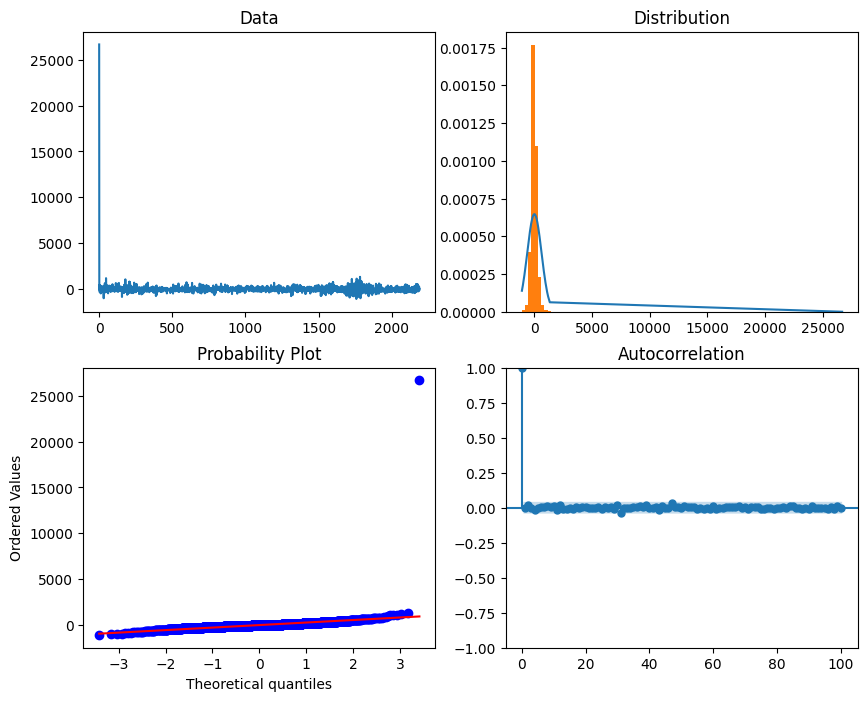

In [16]:
# Fitting이 잘되었는지 확인하기 위해 Residual을 분석한다.
# Residual은 실제 데이터와 추정치의 차이이므로 백색 잡음 (잔차) 이어야 한다.
# 따라서 Residual은 정규분포 특성을 가져야한다. 정규분포 특성을 조사하면
# Fitting이 잘되었는지 확인할 수 있다.
residual = model_fit.resid
checkNormality(residual)  # 육안으로 백색 잡음 형태인지 확인한다

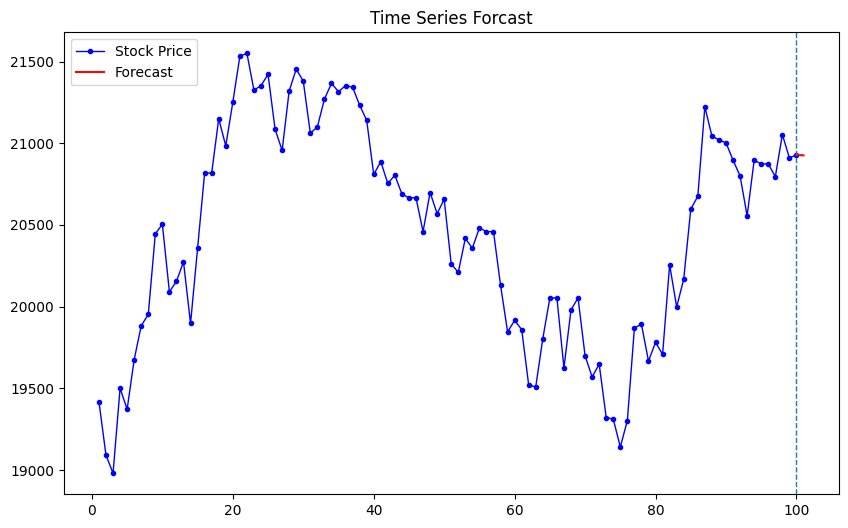

In [17]:
# 향후 10 기간 데이터를 예측한다
forecast = model_fit.forecast(steps=10)[0]
forecast = np.r_[y[-1], forecast]  # y의 마지막 값을 forecast 앞 부분에 넣는다

# 원 시계열과 예측된 시계열을 그린다
ytail = y[len(y)-100:]   # 뒷 부분 100개만 그린다
ax1 = np.arange(1, len(ytail) + 1)
ax2 = np.arange(len(ytail), len(ytail) + len(forecast))
plt.figure(figsize=(10, 6))
plt.plot(ax1, ytail, 'b-o', markersize=3, color='blue', label='Stock Price', linewidth=1)
plt.plot(ax2, forecast, color='red', label='Forecast')
plt.axvline(x=ax1[-1],  linestyle='dashed', linewidth=1)
plt.title("Time Series Forcast")
plt.legend()
plt.show()

# 더 좋은 방법을 찾아보자!!!